# Gibbs Sampling in Python

This is another post from my [PMR](http://www.inf.ed.ac.uk/teaching/courses/pmr/17-18/) exam review. In this post, I'll implement Gibbs Sampling.

Gibbs sampling is useful for sampling from high-dimensional distributions where single-variable conditional distributions are known. 

For example, say it's too expensive to sample from $p(x_0, x_1, x_2, ..., x_d)$. With Gibbs sampling, I initialize all variables to arbitrary values. Then while taking each sample, I also iterate through the dimensions and replace its value with a sample from the univariate conditional distribution. For example I'd update $x_1$ using $p(x_1 \mid x_0, x_2, ..., x_d)$, which is easy to sample over because it's only one dimension.

In [1]:
# imports!
import numpy as np
import matplotlib.pyplot as plt

# helper functions you can skip over :D
SAVE = False
def maybe_save_plot(filename):
    if SAVE:
        plt.tight_layout()
        plt.savefig('images/' + filename, bbox_inches="tight")

## Data generation

My plan is to sample a bunch of points using Gibbs sampling and compare them to points sampled from the true distribution. In this section, I'll define the true joint distribution. 

I'm going to use my favorite 2D Gaussian. This will be 

$$p(a, b) = \mathcal N\left(\left[\begin{array}{c} a \\ b \end{array}\right]; \left[\begin{array}{c}\mu_a \\ \mu_b\end{array}\right], \left[\begin{array}{cc}\sigma_a & cov(a, b) \\ cov(a, b) & \sigma_b\end{array}\right]\right) = \mathcal N\left(\left[\begin{array}{c}a \\ b\end{array}\right]; \left[\begin{array}{c}0 \\ 0\end{array}\right], \left[\begin{array}{cc}1 & 0.5 \\ 0.5 & 1\end{array}\right]\right).$$

In [2]:
# I'll work with 2 dimensions
D = 2

# set up the means
a_mu = 0
b_mu = 0

a_sigma = 1
b_sigma = 1
a_b_cov = 0.5

joint_cov = np.vstack(((a_sigma, a_b_cov), (a_b_cov, b_sigma)))
joint_mu = np.vstack((a_mu, b_mu))

To show what samples from this distribution should look like, I'm going to use my favorite rule: if $\epsilon \sim \mathcal N(0, 1)$, such as data from `np.random.randn`, then I can sample from $\mathcal{N}(\mu, \sigma^2)$ by using $\sigma\epsilon + \mu$.
In the case of multivariate Gaussians, I use the Cholesky decomposition of the covariance matrix (kinda like taking the square root of a variance to get the standard deviation) and then use it and the mean to adjust numbers generated using `np.random.randn`.

In [3]:
N = 10000

L = np.linalg.cholesky(joint_cov)
samples_from_true_distribution =  L @ np.random.randn(D, N) + joint_mu

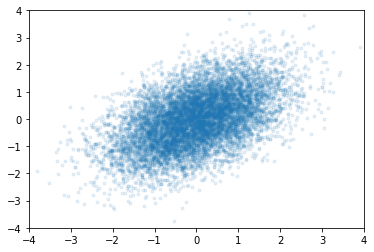

In [4]:
plt.plot(*samples_from_true_distribution, '.', alpha=0.1)
plt.axis([-4, 4, -4, 4])
maybe_save_plot('2018-05-09-joint')
plt.show()

## Conditionals

Gibbs sampling requires conditional distributions for each variable. 

In the case of Gaussians, there's a closed-form for the conditional. 

### Conditionals of multivariate Gaussians

(You can probably skip this part and the next code block if you want.)

Below I have a function that, given the joint and variable index, gives me another function that can sample from the corresponding conditional Gaussian.

In the case of multivariate Gaussians, I'll just use the formula from my [MLPR notes](http://www.inf.ed.ac.uk/teaching/courses/mlpr/2017/notes/w7c_gaussian_processes.html). It says if I have a multivariate Gaussian

$$p(\textbf{f}, \textbf{g}) = 
\mathcal N\left(
\left[\begin{array}{c} \textbf{f} \\ \textbf{g} \end{array}\right];
\left[\begin{array}{c}\textbf{a} \\ \textbf{b}\end{array}\right], 
\left[\begin{array}{cc}A & C^{\top} \\ C & B\end{array}\right]
\right) $$

then the conditional is

$$p(\textbf{f} \mid \textbf{g}) = \mathcal N(\textbf{f}; \textbf{a} + CB^{-1}(\textbf{g} - \textbf{b}), A - CB^{-1}C^{\top})$$

In [5]:
def get_conditional_dist(joint_mu, joint_cov, var_index):
    '''Returns the conditional distribution given the joint distribution and which variable
    the conditional probability should use.
    Right now this only works for 2-variable joint distributions.
    
      joint_mu: joint distribution's mu
      joint_cov: joint distribution's covariance
      var_index: index of the variable in the joint distribution. Everything else will be 
        conditioned on. For example, if the joint distribution p(a, b, c) has mu [mu_a, mu_b, mu_c],
        to get p(c | a, b), use var_index = 2.
      
    returns:
      a function that can sample from the univariate conditional distribution
    '''
    assert joint_mu.shape[0] == 2, 'Sorry, this function only works for 2-dimensional joint distributions right now'
    a = joint_mu[var_index]
    b = joint_mu[~var_index]
    
    A = joint_cov[var_index, var_index]
    B = joint_cov[~var_index, ~var_index]
    C = joint_cov[var_index, ~var_index]
    
    # we're dealing with one dimension so
    B_inv = 1/B
    
    # Return a function that can sample given a value of g
    def dist(g):
        # a + C*B^{-1}(g - b)
        mu = a + C * B_inv * (g - b)
        # A - C * B^{-1} * C^T
        cov = A - B_inv * C * C
        return np.sqrt(cov) * np.random.randn(1) + mu
    
    return dist

Now set up the conditionals for this particular problem.

In [6]:
# Set up the conditional probability distribution for each dimension
# For example, I can sample p(a | b) using sample_for_dim[0].

univariate_conditionals = [
    get_conditional_dist(joint_mu, joint_cov, d)
    for d in range(D)
]

## Gibbs sampling

Now I'll implement the Gibbs sampling algorithm!
What's cool is that `gibbs_sample` function only needs the univariate conditionals and how many samples to take.

In [7]:
def gibbs_sample(univariate_conditionals, sample_count):
    '''Does Gibbs sampling given the distribution's univariate conditionals.
    
    Returns a D x N matrix
    '''
    D = len(univariate_conditionals)
    assert D == 2, "Sorry, this only supports 2 dimensions right now"
    
    # initializes an empty matrix for the samples
    samples = np.zeros((D, sample_count))

    # initialize the first sample to some arbitrary value
    samples[:, 0] = [3, -3]
    
    for i in range(1, sample_count):
        # first set this sample equal to the previous sample
        samples[:, i] = samples[:, i - 1]
        
        # now update the dimension whose turn it is using the conditional distribution
        # pass in all dimension from the previous sample except this dimension
        d = i % D
        samples[d, i] = univariate_conditionals[d](samples[~d, i - 1])
                 
    return samples

## Visualizing

Now I can try it out! I'll use Gibbs sampling to sample a few points and then plot it on top of the real joint distribution from the "Data generation" section.

One thing to keep in mind about Gibbs sampling is that it only updates one dimension at a time. This means that samples from around the same time are correlated with each other. I drew the line connecting sequential samples to show this.

In [8]:
samples = gibbs_sample(univariate_conditionals, sample_count=100)

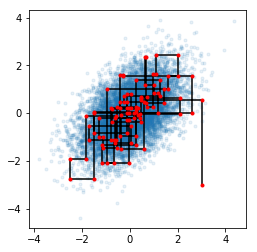

In [9]:
fig, ax = plt.subplots()

ax.plot(*samples_from_true_distribution, '.', alpha=0.1)
ax.plot(*samples, 'k')
ax.plot(*samples, '.r')
ax.axis('square')
maybe_save_plot('2018-05-09-gibbs-100')
plt.show()

Now I can also sample a bunch of points and see how it compares to the original distribution. It looks the same! What's cool is that the one using Gibbs sampling only used samples from the univariate conditionals!

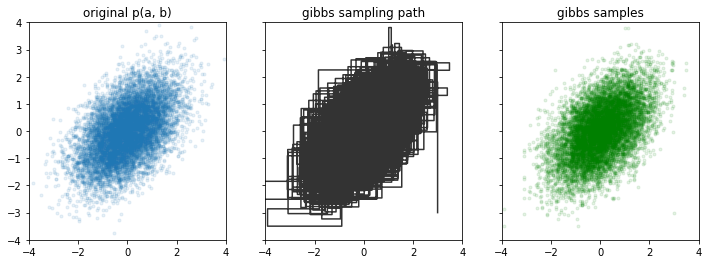

In [10]:
samples = gibbs_sample(univariate_conditionals, sample_count=N)

fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

# set all the axes
axs[0].axis([-4, 4, -4, 4])

axs[0].plot(*samples_from_true_distribution, '.', alpha=0.1)
axs[0].set_title('original p(a, b)')

axs[1].plot(*samples, 'k', alpha=0.8)
axs[1].set_title('gibbs sampling path')

axs[2].plot(*samples, '.g', alpha=0.1)
axs[2].set_title('gibbs samples')

maybe_save_plot('2018-05-09-gibbs-samples')
plt.show()